<a href="https://colab.research.google.com/github/Buushra1dm/ML_Academy_BY_bamboogeeks/blob/main/project1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- **Bushra Dajam**

2- **Shahad hani**

3- **Sahar Mal**

4- **Rawaa Mal**



The Tunisian Company of Electricity and Gas (STEG) is a public and a
non-administrative company, it is responsible for delivering electricity and gas across
Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian
Dinars due to fraudulent manipulations of meters by consumers.
Using the client’s billing history, the aim of the challenge is to detect and recognize
clients involved in fraudulent activities.
The solution will enhance the company’s revenues and reduce the losses caused by
such fraudulent activities.
Data Problem:
Building a model that will help classify which customer is likely to commit fraud and by
that saving the company from making losses.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


In [ ]:
#this function help to convert to date dat tybe
def convert_to_date(df,col):
    df[col] = pd.to_datetime(df[col])

In [ ]:
def convert_t(df):
  convert_to_date(df,'creation_date')
  #df['client_catg'] = df['client_catg'].astype('object')
  #df['disrict'] = df['disrict'].astype('object')

In [ ]:
def convert_invoice(df):
  counter={"ELEC":0,"GAZ":1}
  convert_to_date(df,'invoice_date')
  df['counter_type']=df['counter_type'].replace(counter)

In [ ]:
#The con_level dictionary specifies the columns to aggregate and the aggregation function to apply.
#it calculates the mean for each of the columns.The invoice_train df is grouped by the client_id column, and con_level dictionary is applied to calculate the aggregations.
#The column names of the resulting aggregated DataFrame are modified using a list comprehension. The format is '{col[0]}_{col[1]}', where col[0] represents the original column name and col[1] represents the aggregation function name.
#The index of the aggregated DataFrame is reset, so that the client_id column becomes a regular column.
#Another DataFrame df is created by grouping the invoice_train DataFrame by client_id and calculating the size of each group. The resulting column is named total_invoice.
#The df DataFrame and the agg_invoice DataFrame are merged on the client_id column using a left join. This combines the total invoice count with the aggregated values for each client.
#The final result is the agg_invoice DataFrame, which contains the total invoice count and the mean values for each of the specified columns, grouped by client_id.
def calculate_agg_trans(invoice_train):
    con_level = {
        'consommation_level_1': ['mean'],
        'consommation_level_2': ['mean'],
        'consommation_level_3': ['mean'],
        'consommation_level_4': ['mean']
    }

    agg_invoice = invoice_train.groupby('client_id').agg(con_level)
    agg_invoice.columns = [f'{col[0]}_{col[1]}' for col in agg_invoice.columns]
    agg_invoice.reset_index(inplace=True)

    df = invoice_train.groupby('client_id').size().reset_index(name='total_invoice')

    agg_invoice = pd.merge(df, agg_invoice, on='client_id', how='left')

    return agg_invoice

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load data
client_train = pd.read_csv('/content/drive/MyDrive/train_set/client_train.csv')
invoice_train = pd.read_csv('/content/drive/MyDrive/train_set/invoice_train.csv')

<ipython-input-7-57ed265c79c0>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('/content/drive/MyDrive/train_set/invoice_train.csv')


In [ ]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
client_train.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')

In [ ]:
invoice_train.columns

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

In [ ]:
#n. of rows and columns
client_train.shape

(135493, 6)

In [ ]:
invoice_train.shape

(4476749, 16)

In [ ]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [ ]:
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [ ]:
client_train['target'].value_counts()

0.0    127927
1.0      7566
Name: target, dtype: int64

** it seems not balneced data

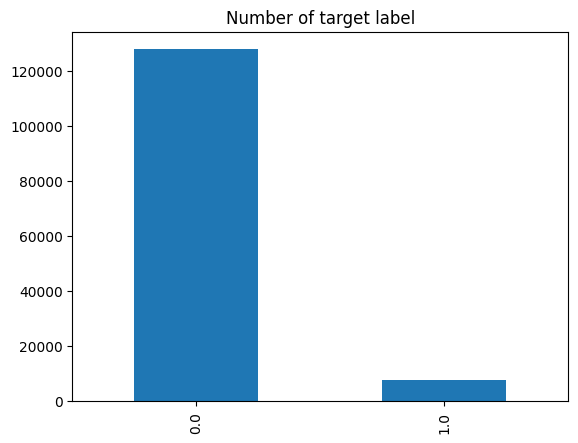

In [ ]:
client_train.target.value_counts().plot(kind ='bar')

plt.title('Number of target label')

#show the plot
plt.show()

0 ---> not fruad


1 ---> fruad



data not balnced

In [ ]:
client_train.dtypes

disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object

In [ ]:
invoice_train.dtypes

client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object

In [ ]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [ ]:
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [ ]:
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [ ]:
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

there is non null values or missing values

In [ ]:
client_train.target.unique()

array([0., 1.])

In [ ]:
for col in client_train:
  if col == 'client_id':
    continue
  print ('\nFrequency of Categories for varible %s'%col)
  print (client_train[col].value_counts())


Frequency of Categories for varible disrict
62    40353
69    34231
60    31922
63    28987
Name: disrict, dtype: int64

Frequency of Categories for varible client_catg
11    131494
12      2321
51      1678
Name: client_catg, dtype: int64

Frequency of Categories for varible region
101    33770
104    12865
311    12406
107     9998
301     9544
103     8964
306     6044
303     5982
310     4851
312     4379
302     4311
304     3828
309     3669
307     3376
305     2716
313     2076
371     2065
105     1645
308      841
106      706
372      644
379      583
399      175
206       53
199        2
Name: region, dtype: int64

Frequency of Categories for varible creation_date
20/11/1997    214
31/12/2004    207
28/05/2002    191
20/11/1996    188
31/12/1996    186
             ... 
27/12/2001      1
21/01/1985      1
15/02/1993      1
21/04/1995      1
25/05/1978      1
Name: creation_date, Length: 8088, dtype: int64

Frequency of Categories for varible target
0.0    127927
1.0     

101,104.311 is  most region

62 is most disrict

client_catg [11,12,51]

array([[<Axes: title={'center': 'disrict'}>,
        <Axes: title={'center': 'client_catg'}>],
       [<Axes: title={'center': 'region'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

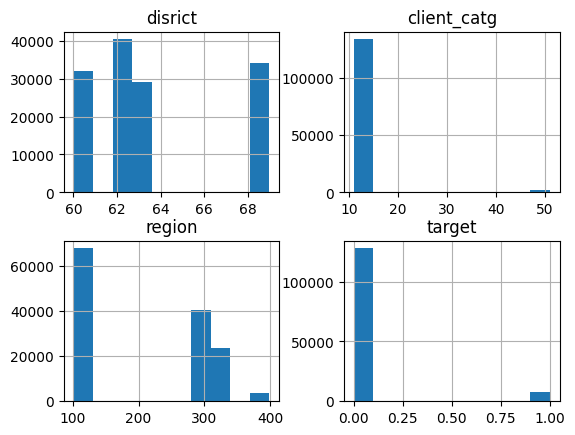

In [ ]:
client_train.hist()

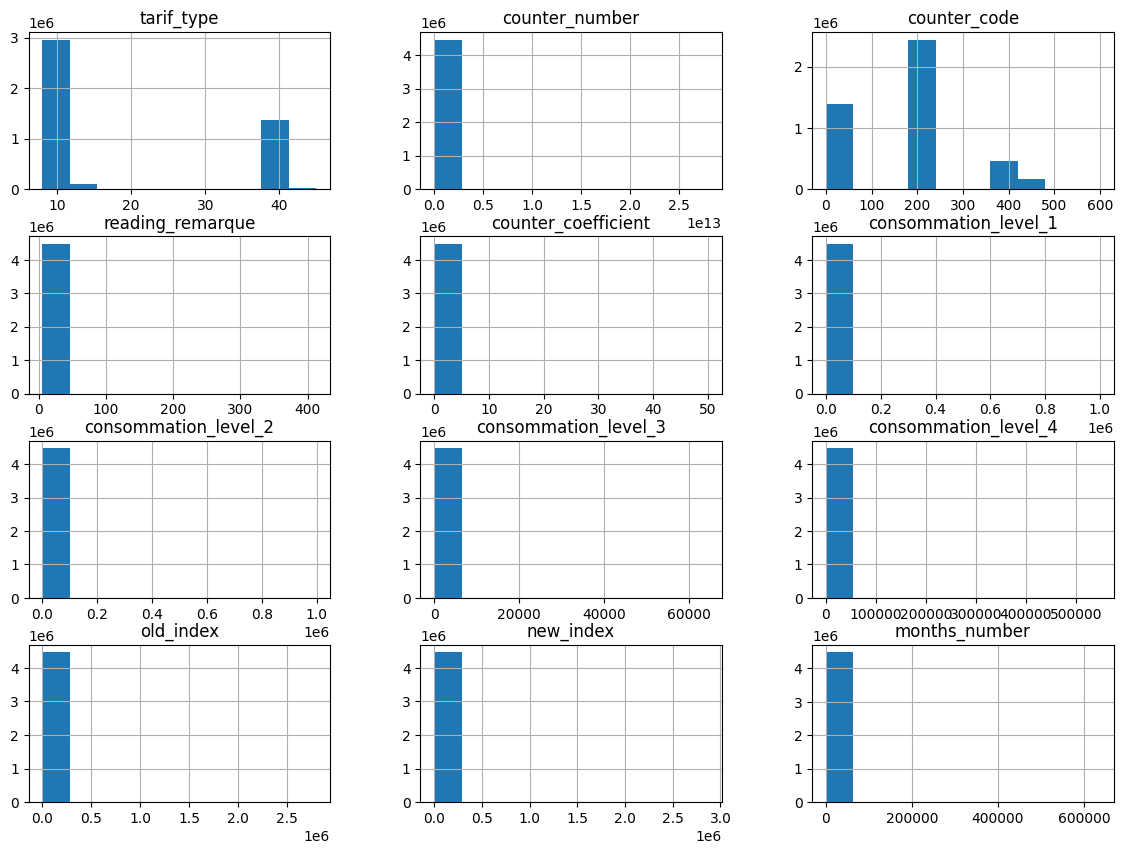

In [ ]:
invoice_train.hist(figsize=(14,10));

In [ ]:
duplicated_rows = client_train[client_train.duplicated()]
print(duplicated_rows)

Empty DataFrame
Columns: [disrict, client_id, client_catg, region, creation_date, target]
Index: []


there is no dublicated rows

In [ ]:
duplicated_rows = invoice_train[invoice_train.duplicated()]
print(duplicated_rows)

                   client_id invoice_date  tarif_type  counter_number  \
951893   train_Client_125864   2011-12-12          11          101545   
1755798   train_Client_25894   2010-07-13          40         6986740   
2137999    train_Client_3636   2012-01-18          40          312650   
2163374   train_Client_37069   2010-10-11          11            5284   
2433919   train_Client_44407   2008-02-28          11           66921   
2805729   train_Client_54609   2010-04-06          11          200912   
3260191   train_Client_66981   2006-07-17          11          132701   
3260198   train_Client_66981   2006-07-17          11          132701   
3394719    train_Client_7066   2014-10-28          40         4463323   
3462929   train_Client_72519   2013-01-21          11          246464   
3628821   train_Client_77029   2012-12-28          11          540417   

        counter_statue  counter_code  reading_remarque  counter_coefficient  \
951893               5           413        

it seems the each clinet has more then one invoice

In [ ]:
for col in invoice_train:
  if col == 'client_id':
    continue
  print ('\nFrequency of Categories for varible %s'%col)
  print (invoice_train[col].value_counts())


Frequency of Categories for varible invoice_date
2019-03-09    4127
2017-03-10    3435
2017-05-09    3411
2017-02-06    3212
2017-03-05    3195
              ... 
2000-10-07       1
1980-10-11       1
1980-09-09       1
1980-08-07       1
1987-10-14       1
Name: invoice_date, Length: 8275, dtype: int64

Frequency of Categories for varible tarif_type
11    2679872
40    1379755
10     276210
15      72422
45      17552
13      11656
14      11611
12      11345
29      10090
9        6039
21        104
8          43
30         35
24          9
18          4
42          1
27          1
Name: tarif_type, dtype: int64

Frequency of Categories for varible counter_number
0                43161
2786               251
630317             230
162709             226
963                220
                 ...  
4920158              1
431951               1
2188701271500        1
508843               1
375249               1
Name: counter_number, Length: 201893, dtype: int64

Frequency of Categor

11, 140, 10 are the most Tariff Types

4,8,2 most months_number

ELEC is  majorty class


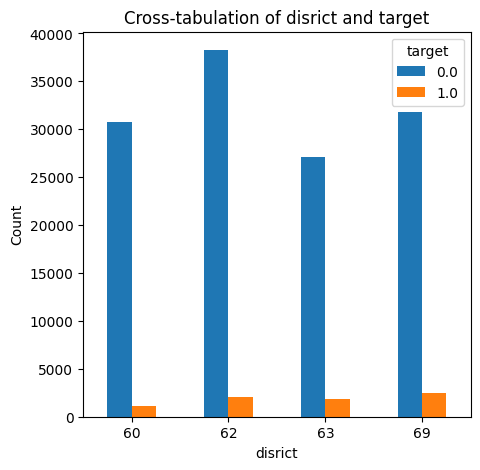

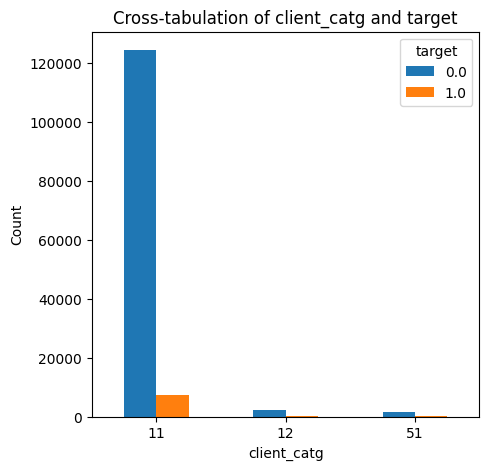

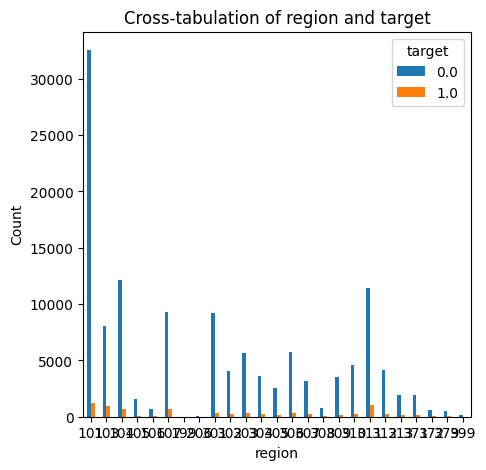

In [ ]:
other_columns = ['disrict', 'client_catg','region']

 #Iterate over each column and plot the cross-tabulation
for col in other_columns:
    CrosstabResult = pd.crosstab(index=client_train[col], columns=client_train['target'])
    CrosstabResult.plot.bar(figsize=(5, 5),rot=0)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Cross-tabulation of {col} and target')
    plt.show()

relation with target

**pre-prossing**

In [ ]:
client_train['target'] = client_train['target'].astype(int)

In [ ]:
convert_t(client_train)

<ipython-input-2-82683d6a1877>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[col] = pd.to_datetime(df[col])


In [ ]:
client_train.dtypes

disrict                   int64
client_id                object
client_catg               int64
region                    int64
creation_date    datetime64[ns]
target                    int64
dtype: object

In [ ]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0
1,69,train_Client_1,11,107,2002-05-29,0
2,62,train_Client_10,11,301,1986-03-13,0
3,69,train_Client_100,11,105,1996-11-07,0
4,62,train_Client_1000,11,303,2014-10-14,0


invoice_train

In [ ]:
convert_invoice(invoice_train)

In [ ]:
invoice_train.dtypes

client_id                       object
invoice_date            datetime64[ns]
tarif_type                       int64
counter_number                   int64
counter_statue                  object
counter_code                     int64
reading_remarque                 int64
counter_coefficient              int64
consommation_level_1             int64
consommation_level_2             int64
consommation_level_3             int64
consommation_level_4             int64
old_index                        int64
new_index                        int64
months_number                    int64
counter_type                     int64
dtype: object

In [ ]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,0


In [ ]:
agg_invoice=calculate_agg_trans(invoice_train)
agg_invoice.head()

,client_id,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [ ]:
train_data = pd.merge(client_train, agg_invoice, on="client_id",how='left')
train_data.head()

,disrict,client_id,client_catg,region,creation_date,target,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,1994-12-31,0,35,352.400000,10.571429,0.000000,0.000000
1,69,train_Client_1,11,107,2002-05-29,0,37,557.540541,0.000000,0.000000,0.000000
2,62,train_Client_10,11,301,1986-03-13,0,18,798.611111,37.888889,0.000000,0.000000
3,69,train_Client_100,11,105,1996-11-07,0,20,1.200000,0.000000,0.000000,0.000000
4,62,train_Client_1000,11,303,2014-10-14,0,14,663.714286,104.857143,117.357143,36.714286


In [ ]:
train_data.shape

(135493, 11)

In [ ]:
df_copy = train_data.copy(deep=True)

In [ ]:
columns_to_delete = ['client_id', 'creation_date']
train_data.drop(columns_to_delete, axis=1, inplace=True)

In [ ]:
train_data.head() #after deleted

,disrict,client_catg,region,target,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,11,101,0,35,352.400000,10.571429,0.000000,0.000000
1,69,11,107,0,37,557.540541,0.000000,0.000000,0.000000
2,62,11,301,0,18,798.611111,37.888889,0.000000,0.000000
3,69,11,105,0,20,1.200000,0.000000,0.000000,0.000000
4,62,11,303,0,14,663.714286,104.857143,117.357143,36.714286


<ipython-input-45-59c34252aadb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_copy.corr(),cmap='Blues')


<Axes: >

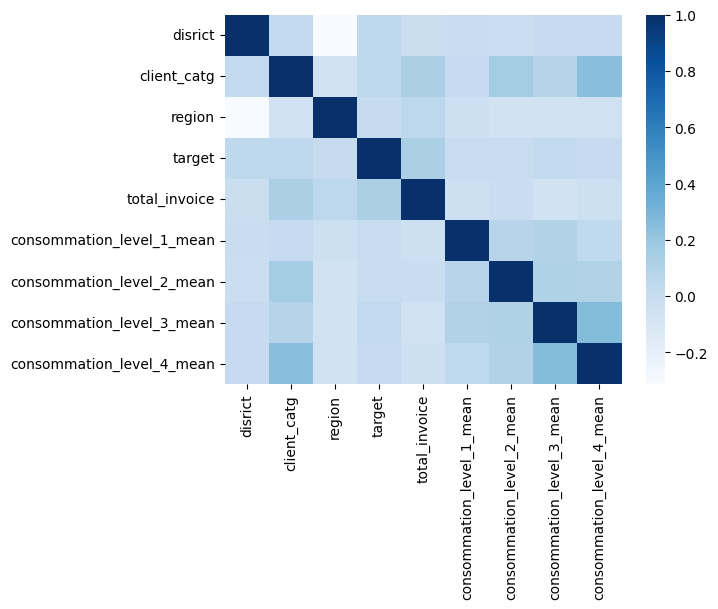

In [ ]:
sns.heatmap(df_copy.corr(),cmap='Blues')

In [ ]:
X = train_data.drop(['target'], axis=1)
y = train_data['target']

**RandomOverSampler**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority") # String
X, y = ros.fit_resample(X, y)

y.value_counts()

0    127927
1    127927
Name: target, dtype: int64

now its balnced data

**train model**

LightGBM is a gradient-boosting framework based on decision trees to increase the efficiency of the model and reduces memory usage.


In [ ]:
X_train, X_vaild, y_train, y_vaild = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_vaild.shape, y_train.shape, y_vaild.shape

((204683, 8), (51171, 8), (204683,), (51171,))

In [ ]:
clf = LGBMClassifier(boosting_type='gbdt', num_iteration=500, silent=True,random_state=0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


LGBMClassifier(num_iteration=500, random_state=0, silent=True)

In [ ]:
y_pred=clf.predict(X_vaild)

In [ ]:
print('LightGBM accuracy is: {0:0.2f}'.format(accuracy_score(y_vaild, y_pred)))

LightGBM accuracy is: 0.80


# **Hyperparamter tuning using GridSearchCV**

> Indented block



In [ ]:
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
}

In [ ]:
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of arg

[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=500, num_iteration=500 will be ignored. Current value: num_iterations=500


GridSearchCV(cv=5,
             estimator=LGBMClassifier(num_iteration=500, random_state=0,
                                      silent=True),
             param_grid={'learning_rate': [0.1, 0.01],
                         'n_estimators': [100, 200],
                         'num_leaves': [20, 30, 40]})

In [ ]:
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 40}


Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 40}


In [ ]:
# Fit the model with the best hyperparameters
best_model = LGBMClassifier(boosting_type='gbdt', num_iteration=500, silent=True, **best_params,random_state=0)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_best = best_model.predict(X_vaild)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
print('LightGBM accuracy with best paramters is: {0:0.2f}'.format(accuracy_score(y_vaild, y_pred_best)))

LightGBM accuracy with best paramters is: 0.82


In [ ]:
y_pred_proba = best_model.predict_proba(X_vaild)[:, 1]
y_pred_proba

array([0.82361251, 0.45712524, 0.94557882, ..., 0.59425932, 0.79438776,
       0.45158327])

**Evalution**

In [ ]:
# Evaluate performance using accuracy score and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

print(f"Accuracy score: {round(accuracy_score(y_vaild, y_pred_best), 3)}\n")
print(f"Confusion matrix\n {confusion_matrix(y_vaild, y_pred_best)}\n")
print(f"Classification report\n {classification_report(y_vaild, y_pred_best)}\n")


Accuracy score: 0.819

Confusion matrix
 [[19820  5742]
 [ 3506 22103]]

Classification report
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     25562
           1       0.79      0.86      0.83     25609

    accuracy                           0.82     51171
   macro avg       0.82      0.82      0.82     51171
weighted avg       0.82      0.82      0.82     51171




In [ ]:
score = roc_auc_score(y_vaild, y_pred_best)
print(f"ROC AUC Score: {score:.4f}")

ROC AUC Score: 0.8192


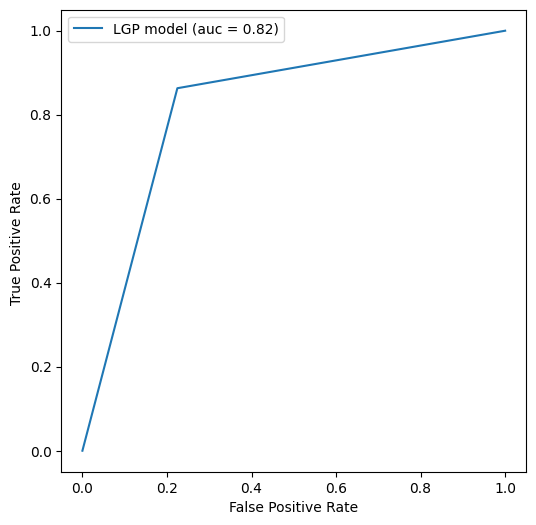

In [ ]:
from sklearn.metrics import roc_curve, auc
lgb_fpr, lgb_tpr, threshold = roc_curve(y_vaild, y_pred_best)
auc_lgb = auc(lgb_fpr, lgb_tpr)
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(lgb_fpr, lgb_tpr, linestyle='-', label='LGP model (auc = %0.2f)' % auc_lgb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate ')

plt.legend(fontsize="10")

plt.show()

AUC under ROC when it area under curve large and go to top-left which is better

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_vaild, y_pred_best)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[19820  5742]
 [ 3506 22103]]

True Positives(TP) =  19820

True Negatives(TN) =  22103

False Positives(FP) =  5742

False Negatives(FN) =  3506


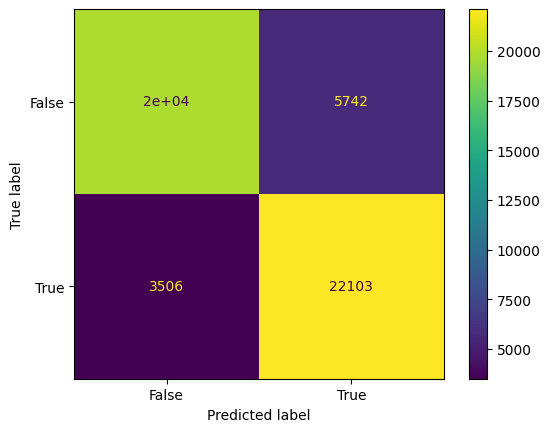

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_vaild, y_pred_best)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

**test set**

In [ ]:
client_test=pd.read_csv('/content/drive/MyDrive/test_set/client_test.csv')
invoice_test=pd.read_csv('/content/drive/MyDrive/test_set/invoice_test.csv')

In [ ]:
convert_t(client_test)
convert_invoice(invoice_test)

<ipython-input-2-82683d6a1877>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df[col] = pd.to_datetime(df[col])


In [ ]:
client_test.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
dtype: int64

In [ ]:
invoice_test.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

no null or missing valuse on test set

In [ ]:
agg_invoice_test=calculate_agg_trans(invoice_test)
agg_invoice_test.head()

,client_id,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,test_Client_0,37,488.135135,3.243243,0.000000,0.000000
1,test_Client_1,22,1091.409091,843.136364,182.318182,586.318182
2,test_Client_10,74,554.040541,37.364865,15.743243,0.162162
3,test_Client_100,40,244.350000,0.000000,0.000000,0.000000
4,test_Client_1000,53,568.188679,145.056604,33.679245,0.000000


In [ ]:
test_data = pd.merge(client_test, agg_invoice_test, on="client_id")
test_data.head()

,disrict,client_id,client_catg,region,creation_date,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,62,test_Client_0,11,307,2002-05-28,37,488.135135,3.243243,0.000000,0.000000
1,69,test_Client_1,11,103,2009-06-08,22,1091.409091,843.136364,182.318182,586.318182
2,62,test_Client_10,11,310,2004-07-04,74,554.040541,37.364865,15.743243,0.162162
3,60,test_Client_100,11,101,1992-08-10,40,244.350000,0.000000,0.000000,0.000000
4,62,test_Client_1000,11,301,1977-07-21,53,568.188679,145.056604,33.679245,0.000000


In [ ]:
test_data.shape

(58069, 10)

In [ ]:
c_id = test_data['client_id'].copy()
c_id

0           test_Client_0
1           test_Client_1
2          test_Client_10
3         test_Client_100
4        test_Client_1000
               ...       
58064    test_Client_9995
58065    test_Client_9996
58066    test_Client_9997
58067    test_Client_9998
58068    test_Client_9999
Name: client_id, Length: 58069, dtype: object

In [ ]:
col_del=['creation_date','client_id']

test_data.drop(col_del, axis=1, inplace=True)
test_data.head()

,disrict,client_catg,region,total_invoice,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,62,11,307,37,488.135135,3.243243,0.000000,0.000000
1,69,11,103,22,1091.409091,843.136364,182.318182,586.318182
2,62,11,310,74,554.040541,37.364865,15.743243,0.162162
3,60,11,101,40,244.350000,0.000000,0.000000,0.000000
4,62,11,301,53,568.188679,145.056604,33.679245,0.000000


In [ ]:
test_data.shape

(58069, 8)

In [ ]:
y_proba = best_model.predict_proba(test_data) #model


In [ ]:
y_proba = pd.DataFrame(y_proba)
y_proba.head()

,0,1
0,0.630475,0.369525
1,0.329014,0.670986
2,0.504189,0.495811
3,0.612252,0.387748
4,0.830602,0.169398


In [ ]:
submission = pd.DataFrame({
        "client_id": c_id,
        "target": y_proba[1]
    })

submission.to_csv('Sample_submission.csv', index=False)

In [ ]:
submission

,client_id,target
0,test_Client_0,0.369525
1,test_Client_1,0.670986
2,test_Client_10,0.495811
3,test_Client_100,0.387748
4,test_Client_1000,0.169398
...,...,...
58064,test_Client_9995,0.000840
58065,test_Client_9996,0.510953
58066,test_Client_9997,0.467075
58067,test_Client_9998,0.002983
